# Bayesian Data Analysis in Python

Bayesian data analysis is an increasingly popular method of statistical inference, used to determine conditional probability without having to rely on fixed constants such as confidence levels or p-values. In this course, we’ll learn how Bayesian data analysis works, how it differs from the classical approach, and why it’s an indispensable part of our data science toolbox. We’ll get to grips with A/B testing, decision analysis, and linear regression modeling using a Bayesian approach as we analyze real-world advertising, sales, and bike rental data. Finally, we’ll get hands-on with the PyMC3 library, which will make it easier for us to design, fit, and interpret Bayesian models.

## 1. The Bayesian way

Our first steps in the Bayesian world. In this chapter, we’ll be introduced to the basic concepts of probability and statistical distributions, as well as to the famous Bayes' Theorem, the cornerstone of Bayesian methods. Finally, we’ll build our first Bayesian model to draw conclusions from randomized coin tosses.

<img src="fig/this_is_the_way.jpg" width=400  />

What is Bayes? Bayesian inference means updating one's belief about something as the new informationbecomes available. It is quite different from the classical approach, see the table below:

<img src="fig/bayes_vs_class.png" width=400  />

The main advantages of the Bayesian approach over Frequentist (classical) approach:
- Natural handling of uncertainty (because parameters have distributions!).
- Possibility to include expert opinion or domain knowledge in the model (because probability means the degree of belief!).
- No need to rely on fixed constants such as p-values.
- Statistically correct even with little data.
- Often coincides with frequentist results, but offers more flexibility to build custom models.

Based on the description above, we have the general idea of what the Bayesian approach is all about. Among other things, we know that for a Bayesian, parameters of statistical models are random variables which can be described by probability distributions.

#### 1.1 Probability and Bayes' Theorem
SCENARIO: _You have a regular deck of 52 well-shuffled playing cards. The deck consists of 4 suits, and there are 13 cards in each suite: ranks 2 through 10, a jack, a queen, a king, and an ace. This means that in the whole deck of 52, there are four of each distinct rank: four aces, four kings, four tens, four fives, etc._

Since there are 52 distinct cards, the probability of drawing any one particular card is 1/52. The goal is to calculate the probabilities of drawing some specific combinations of cards, as described in the instructions/comments in the cells below.

In [45]:
# Install packages https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
# !conda install --yes --prefix {sys.prefix} pymc3
# !conda install --yes --prefix {sys.prefix} arviz

In [1]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import uniform, binom
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Calculate probability of drawing a king or queen
p_king_or_queen = 4*(1/52) + 4*(1/52) # 4 kings OR queens
print("The probability of drawing a king or queen is {0:.2f}.".format(p_king_or_queen))

# Calculate probability of drawing <= 5
p_five_or_less = 4*4*(1/52) # 4 different cards: 2, 3, 4, 5 times 4 each
print("The probability of drawing <= 5 is {0:.2f}.".format(p_five_or_less))

# Calculate probability of drawing four aces
p_all_four_aces = 4*(1/52)*3*(1/51)*2*(1/50)*1*(1/49) # drawing without replacement
print("The probability of drawing all four aces in row is {0:.8f}.".format(p_all_four_aces))

The probability of drawing a king or queen is 0.15.
The probability of drawing <= 5 is 0.31.
The probability of drawing all four aces in row is 0.00000369.


Probably well done! The chance of drawing four aces straight is 0.00037%, so don't hope for it too much! Now that we're an expert in manipulating probabilities, let's take a look at Bayes' Theorem and how to use it to detect spam messages.

SCENARIO: _While browsing your inbox, you have figured out that quite a few of the emails you would rather not waste your time on reading contain exclamatory statements, such as "BUY NOW!!!". You start thinking that the presence of three exclamation marks next to each other might be a good spam predictor! Hence you've prepared a DataFrame called `emails` with two variables: `spam`, whether the email was spam, and `contains_3_exlc`, whether it contains the string "!!!"._

__NOTE:__ The `emails` dataset is not available online and it is built manually for this exercise.

Our job is to calculate the probability of the email being spam given that it contains three exclamation marks. Let's tackle it step by step! Here is Bayes' formula for our reference:

$$ P(A | B) = \frac{ P(B | A) \times P(A)}{ P(B) } $$

In [6]:
# load and preview the data
spam = [False, False,  True, False, False, False, False, False, False, False, False, False, False,  True, False,  True, False,
        True, False, False, False,  True, False, False,  True, False, False, True, False, False, False,  True, False, False, 
        False,  True, False, False, False,  True, False, False, False, False, False, False, False, False,  True, False, False,
        True, False, False, True, False, False,  True,  True, False, False, True, False, True,  True, False, False, False,  
        True, False, False,  True, False, False, False,  True,  True, False, False, False, False, False, False, True, False,
        True,  True, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, 
        False, False,  True, False, False, False, True, False, False, False, False,  True,  True, False, False, False, False, 
        False, False, False, False, False, False,  True, False, False, False, False, False, False,  True, False, False, False, 
        False,  True, False, False,  True,  True, False,  True, False, False, False, False,  True, False, False, False, False, 
        False,  True, False,  True,  True, False, False, False,  True, False,  True, False,  True, False, False, False,  True, 
        False, False, False, False, False, False, False, False, False, False, True,  True,  True, False, False, False, False, 
        False, False, False, False, False, False, False,  True, False, False, False, True, False, False,  True, False, False, 
        False]
contains_3_excl = [False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True,
                   True, False,  True, False, False, False,  True, False, False,  True, False, False, False, False, False, 
                   False, False, False, False, False,  True, False, False, False,  True, False, False, False, False, False, 
                   False, False, False,  True, False, False,  True, False, False, False, False, False,  True,  True, False,
                   True, False, False, False, False, False, False, False,  True, False, False, False, False, False, False,
                   True,  True, False, False, False, False, False, False,  True, False, False,  True, False, False, False, 
                   False, False, False, False, False, False,  True,  True, False, False, False, False, False, False, False, 
                   False, False, False, True, False, False, False, False, False,  True, False, False, False, False, False, 
                   False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, 
                   False, False,  True, False, False,  True,  True, False,  True, False, False, False, False,  True, False, 
                   False, False, False, False,  True, False,  True, False, False,  True, False,  True, False, False, False,  
                   True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
                   False, False, True, False, False,  True, False, False, False]

emails = pd.DataFrame({'spam':spam, 'contains_3_excl':contains_3_excl})
emails.head()

,spam,contains_3_excl
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False


In [7]:
# Calculate and print the unconditional probability of spam
p_spam = emails['spam'].mean()
print("The unconditional probability of spam is {0:.2f}.".format(p_spam))

# Calculate and print the unconditional probability of "!!!"
p_3_excl = emails["contains_3_excl"].mean()
print("The unconditional probability of \"!!!\" is {0:.2f}.".format(p_3_excl))

# Calculate and print the probability of "!!!" given spam
p_3_excl_given_spam = emails.loc[emails["spam"] == True ]["contains_3_excl"].mean() 
print("The probability of \"!!!\" given spam is {0:.2f}.".format(p_3_excl_given_spam))

# Calculate and print the probability of spam given "!!!"
p_spam_given_3_excl = p_3_excl_given_spam * p_spam / p_3_excl
print("The probability of spam given \"!!!\" is {0:.2f}.".format(p_spam_given_3_excl))

The unconditional probability of spam is 0.24.
The unconditional probability of "!!!" is 0.17.
The probability of "!!!" given spam is 0.60.
The probability of spam given "!!!" is 0.86.


If an email contains the '!!!', you can be 85% sure it is spam! Next, let's use Bayes' Theorem in practice once again, but this time without the data neatly gathered in a DataFrame!

SCENARIO: _A doctor suspects a disease in their patient, so they run a medical test. The test's manufacturer claims that 99% of sick patients test positive, while the doctor has observed that the test comes back positive in 2% of all cases. The suspected disease is quite rare: only 1 in 1000 people suffer from it._

The test result came back positive. __What is the probability that the patient is indeed sick?__ We can use Bayes' Theorem to answer this question. Here is what you should calculate:

$$ P(\text{sick} | \text{positive}) = \frac{ P(\text{positive} | \text{sick}) \times P(\text{sick})}{ P(\text{positive}) } $$

In [8]:
print(0.99 * (1/1000) / 0.02)

0.049499999999999995


Not very intuitive, is it? Even though the test is great at discovering the disease and raises false alarms rather seldom, a positive result means only a 5% probability that the patient is sick!

#### 1.2 Tasting the Bayes

In this part we will use a custom `get_heads_prob()` function that estimates the probability of success of a binomial distribution. In this exercise, we will use it and verify whether it does its job well in a coin-flipping experiment.

Watch out for the confusion: there are two different probability distributions involved! One is the binomial, which we use to model the coin-flipping. It's a discrete distribution with two possible values (heads or tails) parametrized with the probability of success (tossing heads). The Bayesian estimate of this parameter is another, continuous probability distribution. We don't know what kind of distribution it is, but we can estimate it with `get_heads_prob()` and visualize it.

In [9]:
def get_heads_prob(tosses):
    """
    Estimates the probability of success of a binomial distribution.

    Parameters
    ----------
    tosses : array
        List of coin-flipping trials with two possible values 0s and 1s.

    Returns
    -------
    probability distribution: array
        continuous probability of success (tossing heads).

    See also
    --------
    https://campus.datacamp.com/courses/bayesian-data-analysis-in-python/the-bayesian-way?ex=9.
    """
    
    num_heads = np.sum(tosses)
    return np.random.beta(num_heads + 1, 
                          len(tosses) - num_heads + 1, 
                          1000)

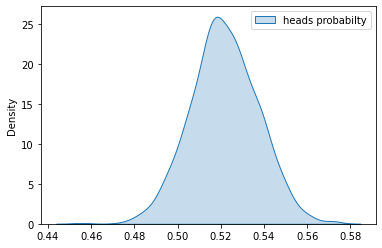

In [10]:
# Generate 1000 coin tosses of a "fair" coin
tosses = np.random.binomial(1, 0.5, size=1000)

# Estimate the heads probability
heads_prob = get_heads_prob(tosses)

# Plot the distribution of heads probability
sns.kdeplot(heads_prob, shade=True, label="heads probabilty")
plt.legend()
plt.show()

The density plot peaks around 50%, indicating that the model has estimated the heads probability well. Now that we're familiar with `get_heads_prob()`, let's explore it in more detail in the next exercise!

SCENARIO: _Imagine you are a frequentist (just for a day), and you've been tasked with estimating the probability of tossing heads with a (possibly biased) coin, but without observing any tosses. What would you say? It's impossible, there is no data! Then, you are allowed to flip the coin once. You get tails. What do you say now? Well, if that's all your data, you'd say the heads probability is 0%._

You can probably feel deep inside that these answers are not the best ones. But what would be better? What would a Bayesian say? Let's find out!

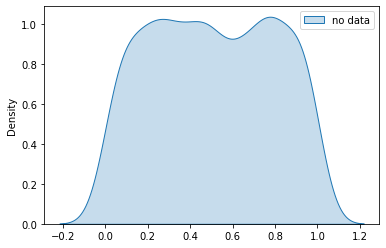

In [11]:
# Estimate and plot heads probability based on no data
heads_prob_nodata = get_heads_prob([]) # heads probability based on an empty list
sns.kdeplot(heads_prob_nodata, shade=True, label="no data")
plt.legend()
plt.show()

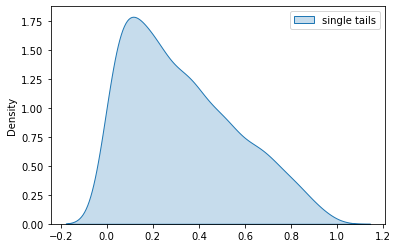

In [12]:
# Estimate and plot heads probability based on a single tails
heads_prob_onetails = get_heads_prob([0]) # a single tail (a list with a single 0)
sns.kdeplot(heads_prob_onetails, shade=True, label="single tails")
plt.legend()
plt.show()

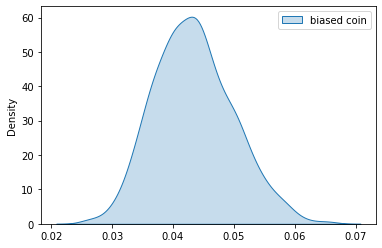

In [13]:
# Estimate and plot heads probability based on 1000 tosses with a biased coin which comes up heads only 5% of all times
biased_tosses = np.random.binomial(1, 0.05, size=1000)
heads_prob_biased = get_heads_prob(biased_tosses)
sns.kdeplot(heads_prob_biased, shade=True, label="biased coin")
plt.legend()
plt.show()

That's interesting! With no data, each possible value of the heads probabilty is equally likely! That's the Bayesian way of saying 'we don't know'. Having seen a single tails, the model suspects that tails is more likely than heads, but since there is so little data, it is not very sure about it, so other values are possible, too. Having seen 1000 tosses, 5% of them heads, the model is certain: the heads probability is around 5%. __We have just witnessed the Bayesian approach at its core: as more data come in, we update our belief about the parameter, and with more data we become more certain about our estimate!__

In the last two exercises, we have examined the `get_heads_prob()` function to discover how the model estimates the probability of tossing heads and how it updates its estimate as more data comes in.

Now, let's get down to some serious stuff:

SCENARIO: _Would you like to play coin flipping against your friend? She is willing to play, as long as you use her special lucky coin. The tosses variable contains a list of 1000 results of tossing her coin. Will you play?_

In [14]:
tosses = [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 
          1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 
          1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 
          1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 
          0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 
          1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 
          1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 
          0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 
          1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 
          0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 
          1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 
          1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 
          1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 
          1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 
          1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 
          1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 
          1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 
          1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

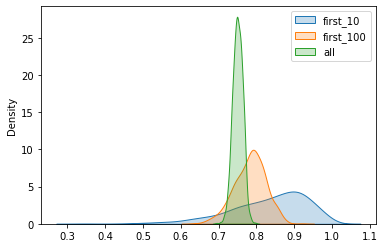

In [15]:
# Assign first 10 and 100 tosses to separate variables
tosses_first_10 = tosses[:10]
tosses_first_100 = tosses[:100]

# Get head probabilities for first 10, first 100, and all tossses
heads_prob_first_10 = get_heads_prob(tosses_first_10)
heads_prob_first_100 = get_heads_prob(tosses_first_100)
heads_prob_all = get_heads_prob(tosses)

# Plot density of head probability for each subset of tosses
sns.kdeplot(heads_prob_first_10, shade=True, label="first_10")
sns.kdeplot(heads_prob_first_100, shade=True, label="first_100")
sns.kdeplot(heads_prob_all, shade=True, label="all")
plt.legend()
plt.show()

The coin seems to be biased, it is more likely to come up heads than tails. You're right refusing to play with this particular coin. The chance it comes up heads is 75% to be precise, and the model got it right - having seen all 1000 tosses, the estimated distribution peaks at 0.75. With smaller data samples, however, the model didn't have the chance to learn the true value. You can see how uncertain it is from the width of the corresponding distributions. Are you curious how this model works, and how it updates its estimates with more data? Head off to Chapter 2 to find out!

## 2. Bayesian estimation

It’s time to look under the Bayesian hood. We’ll learn how to apply Bayes' Theorem to drug-effectiveness data to estimate the parameters of probability distributions using the grid approximation technique, and update these estimates as new data become available. Next, we’ll learn how to incorporate prior knowledge into the model before finally practicing the important skill of reporting results to a non-technical audience.

#### 2.1 Under the Bayesian hood

SCENARIO: _Congratulations! You have just been hired as a data analyst at your government's Department of Health. The cabinet is considering the purchase of a brand-new drug against a deadly and contagious virus. There are some doubts, however, regarding how effective the new drug is against the virus. You have been tasked with estimating the drug's efficacy rate, i.e. the percentage of patients cured by the drug._

_An experiment was quickly set up in which 10 sick patients have been treated with the drug. Once you know how many of them are cured, you can use the binomial distribution with a cured patient being a "success" and the efficacy rate being the "probability of success". While you are waiting for the experiment's results, you decide to prepare the parameter grid._

In [16]:
# Create cured patients array from 1 to 10
num_patients_cured = np.arange(0, 11, 1)

# Create efficacy rate array from 0 to 1 by 0.01 (1%-100%)
efficacy_rate = np.arange(0, 1.01, 0.01)

# Combine the two arrays in one DataFrame
# meaning creating a grid of all possible combination of success and their probabilities
df = pd.DataFrame([(x, y) for x in num_patients_cured for y in efficacy_rate])

# Name the columns
df.columns = ['num_patients_cured', 'efficacy_rate']

# Print df
display(df)

,num_patients_cured,efficacy_rate
0,0,0.00
1,0,0.01
2,0,0.02
3,0,0.03
4,0,0.04
...,...,...
1106,10,0.96
1107,10,0.97
1108,10,0.98
1109,10,0.99


We have prepared a fine grid of possible values for the parameter you want to estimate (the efficacy rate), for all possible results of the experiment (the number of patients cured by the drug). Uh-oh 🤓, it looks like the results have just arrived! Let's make use of them in the next exercise!

According to the experiment's outcomes, out of __10 sick patients treated with the drug, 9 have been cured__. What can we say about the drug's efficacy rate based on such a small sample? Assume we have no prior knowledge whatsoever regarding how good the drug is.

$$ P(\text{parameters} | \text{data}) = \frac{ P(\text{data} | \text{parameters}) \times P(\text{parameters})}{ P(\text{data}) } $$

- __P(parameters | data) → posterior distribution:__ what we know about the parameters after having seen the data
- __P(parameters) → prior distribution:__ what we know about the parameters before seeing any data
- __P(data | parameters) → likelihood__ of the data according to our statistical model
- __P(data) →__ scaling factor


In [17]:
# Calculate the prior efficacy rate and the likelihood
df["prior"] = uniform.pdf(df["efficacy_rate"]) # meaning that all scenarios have the same chance to happen
df["likelihood"] = binom.pmf(df["num_patients_cured"], 10, df["efficacy_rate"]) # here we use the sample size 

# Calculate the posterior efficacy rate and scale it to sum up to one
# We use the function above to finalize our parameters grid
df["posterior_prob"] = df["prior"] * df["likelihood"]
df["posterior_prob"] /= df["posterior_prob"].sum() # scale the posterior_prob to get a sum of 1

# Print df
display(df)

,num_patients_cured,efficacy_rate,prior,likelihood,posterior_prob
0,0,0.00,1.0,1.000000,0.009901
1,0,0.01,1.0,0.904382,0.008954
2,0,0.02,1.0,0.817073,0.008090
3,0,0.03,1.0,0.737424,0.007301
4,0,0.04,1.0,0.664833,0.006583
...,...,...,...,...,...
1106,10,0.96,1.0,0.664833,0.006583
1107,10,0.97,1.0,0.737424,0.007301
1108,10,0.98,1.0,0.817073,0.008090
1109,10,0.99,1.0,0.904382,0.008954


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_24408\1192329434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9_of_10_cured["posterior_prob"] /= df_9_of_10_cured["posterior_prob"].sum() # scale the posterior_prob to get a sum of 1


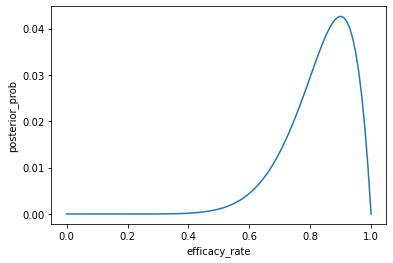

In [18]:
# Compute the posterior probability of observing 9 cured patients
df_9_of_10_cured = df.loc[df["num_patients_cured"] == 9]
df_9_of_10_cured["posterior_prob"] /= df_9_of_10_cured["posterior_prob"].sum() # scale the posterior_prob to get a sum of 1

# Plot the drug's posterior efficacy rate
sns.lineplot(data=df_9_of_10_cured, x="efficacy_rate", y="posterior_prob")
plt.show()

As we might have expected, observing 9 out of 10 patients cured results in the posterior efficacy rate of 90% being very likely. Notice, however, how much uncertainty there is in the posterior distribution: even the efficacy of 50% is plausible. This is the result of a very small data sample and a great example of how Bayesian parameter estimates incorporate uncertainty!

Unfortunately, due to a small data sample, this distribution is quite wide, indicating much uncertainty regarding the drug's quality. Luckily, testing of the drug continues, and a group of another 12 sick patients 🤒 have been treated, 10 of whom were cured. We need to update our posterior distribution with these new data!

This is easy to do with the Bayesian approach. We simply need to run the grid approximation similarly as before, but with a different prior. We can use all our knowledge about the efficacy rate (embodied by the posterior distribution from the previous exercise) as a new prior! Then, we recompute the likelihood for the new data, and get the new posterior!

In [19]:
# Create new cured patients array from 1 to 10
new_num_patients_cured = np.arange(0, 13, 1)

# The efficacy rate didn't change
# Combine the two arrays in one DataFrame
# meaning creating a grid of all possible combination of success and their probabilities
new_df = pd.DataFrame([(x, y) for x in new_num_patients_cured for y in efficacy_rate])

# Name the columns
new_df.columns = ['num_patients_cured', 'efficacy_rate']

# Print df
display(new_df)

# NOTE: since we know that we have 10 cured personas, we could only build a grid for new_num_patients_cured=10

,num_patients_cured,efficacy_rate
0,0,0.00
1,0,0.01
2,0,0.02
3,0,0.03
4,0,0.04
...,...,...
1308,12,0.96
1309,12,0.97
1310,12,0.98
1311,12,0.99


,num_patients_cured,efficacy_rate,prior,likelihood,posterior_prob
0,0,0.00,0.000000e+00,1.000000,0.000000e+00
1,0,0.01,1.089999e-18,0.886385,9.661585e-19
2,0,0.02,5.524422e-16,0.784717,4.335107e-16
3,0,0.03,2.102102e-14,0.693842,1.458528e-14
4,0,0.04,2.770780e-13,0.612710,1.697684e-13
...,...,...,...,...,...
1308,12,0.96,3.049944e-02,0.612710,1.868731e-02
1309,12,0.97,2.511063e-02,0.693842,1.742282e-02
1310,12,0.98,1.835927e-02,0.784717,1.440683e-02
1311,12,0.99,1.005791e-02,0.886385,8.915176e-03


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_24408\3985422740.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_of_12_cured["posterior_prob"] /= df_10_of_12_cured["posterior_prob"].sum()


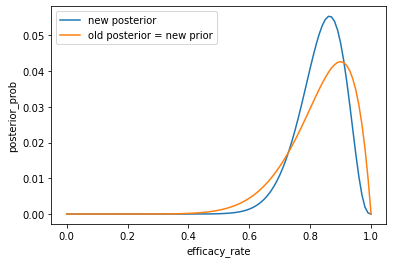

In [20]:
# Build a new grid and assign old posterior to new prior and calculate likelihood
new_prior = [df_9_of_10_cured["posterior_prob"] for i in  new_num_patients_cured]
new_prior = pd.concat(new_prior, ignore_index=True)
new_df["prior"] = new_prior
new_df["likelihood"] = binom.pmf(new_df["num_patients_cured"], 12, new_df["efficacy_rate"])

# Calculate new posterior and scale it
new_df["posterior_prob"] = new_df["prior"] * new_df["likelihood"]
new_df["posterior_prob"] /= new_df["posterior_prob"].sum()
display(new_df)

# Compute the posterior probability of observing 10 cured patients
df_10_of_12_cured = new_df.loc[ new_df['num_patients_cured'] == 10]
df_10_of_12_cured["posterior_prob"] /= df_10_of_12_cured["posterior_prob"].sum()

# Plot the drug's posterior efficacy rate
sns.lineplot(data=df_10_of_12_cured, x="efficacy_rate", y="posterior_prob", label="new posterior")
sns.lineplot(data=df_9_of_10_cured, x="efficacy_rate", y="posterior_prob", label="old posterior = new prior")
plt.legend()
plt.show()

The knowledge about the first 10 patients is already encoded in the old posterior, which became the new prior. The difference between these two distributions reflects what we have learned from the data on all patients: the first 10, and the next 12.

#### 2.2 Prior belief
Choosing the prior distribution is a very important step in Bayesian data analysis. Some things to remember before choosing the prior:

- Prior distribution chosen before we see the data.
- Prior choice can impact posterior results (especially with little data)
- To avoid cherry-picking, prior choices should be:
    - clearly stated,
    - explainable: based on previous research, sensible assumptions, expert opinion, etc.
- Some priors, multiplied with speci,c likelihoods, yield known posteriors. They are known as __conjugate priors__.

SCENARIO: _You continue working on your task to estimate the new drug's efficacy, but with the small data sample you had, you know there is a lot of uncertainty in your estimate. Luckily, a couple of neighboring countries managed to conduct more extensive experiments and have just published their results. You can use them as priors in your analysis!_

_Having browsed all the publications, you conclude that the reported efficacy rates are mostly between 70% and 90%. A couple of results below 50% were recorded too, but not many._

_You have just decided to use a Beta(5, 2) prior for the efficacy rate. You are also using the binomial distribution to model the data (curing a sick patient is a "success", remember?). Since the beta distribution is a __conjugate prior__ for the binomial likelihood, you can simply simulate the posterior! Can you simulate the posterior distribution? Recall that altogether we have data on 22 patients, 19 of whom have been cured._

We know that if the prior is $Beta(a, b)$, then the posterior is $Beta(x, y)$, with:

$x = NumberOfSuccesses + a$\
$y = NumberOfObservations - NumberOfSuccesses + b$

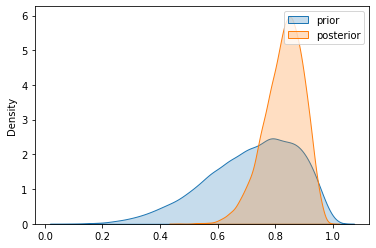

In [21]:
# Define the number of patients treated and cured
num_patients_treated = 22
num_patients_cured = 19

# Simulate 10000 draws from the posterior distribuition
prior = np.random.beta(5, 2, 10000)
posterior_draws = np.random.beta(19 + 5, 22 - 19 + 2, 10000)


# Plot the posterior distribution
sns.kdeplot(prior, shade=True, label="prior")
sns.kdeplot(posterior_draws, shade=True, label="posterior")
plt.legend()
plt.show()

Notice that the posterior distribuion has a slightly longer tail on the left-hand side, allowing for efficacy rates as small as 50%, even though in your data you observe 86% (19 out of 22). This is the impact of the prior: we learn not only from our own small data, but also from other countries' experience! Now that we know how obtain posterior distributions of the parameters, let's talk about how to report these results!

#### 2.3 Reporting Bayesian results

SCENARIO: _You continue working at your government's Department of Health. You have been tasked with filling the following memo with numbers, before it is sent to the secretary._

_"Based on the experiments carried out by ourselves and neighboring countries, should we distribute the drug, we can expect __XXX__ infected people to be cured. There is a 50% probability the number of cured infections will amount to at least __XXX__, and with 90% probability it will not be less than __XXX__."_

The array of posterior draws of the drug's efficacy rate we have estimated before is available to us as `posterior_draws`.

We nedd to calculate the three numbers needed to fill in the memo, knowing there are 100,000 infections at the moment. 

In [22]:
# Calculate the expected number of people cured
cured_expected = np.mean(posterior_draws) * 100000

# Calculate the minimum number of people cured with 50% probability
min_cured_50_perc = np.median(posterior_draws) * 100000

# Calculate the minimum number of people cured with 90% probability
min_cured_90_perc = np.percentile(posterior_draws, 10) * 100000

# Print the filled-in memo
memo = f"""Based on the experiments carried out by ourselves and neighboring countries, 
should we distribute the drug, we can expect {int(cured_expected)} infected people to be cured.
There is a 50% probability the number of cured infections will amount to at least {int(min_cured_50_perc)},
and with 90% probability it will not be less than {int(min_cured_90_perc)}."""

print(memo)

Based on the experiments carried out by ourselves and neighboring countries, 
should we distribute the drug, we can expect 82861 infected people to be cured.
There is a 50% probability the number of cured infections will amount to at least 83620,
and with 90% probability it will not be less than 73629.


Our memo compresses the posterior distribution of the drug's efficacy to a couple of useful numbers, certainly helping the secretary decide whether to buy the new drug. However, these numbers convey no information as to how uncertain the estimation is. Let's try quantifying this uncertainty next!

SCENARIO: _You know that reporting bare point estimates is not enough. It would be great to provide a measure of uncertainty in the drug's efficacy rate estimate, and you have all the means to do so. You decide to add the following to the memo._

_"The experimental results indicate that with a 90% probability the new drug's efficacy rate is between __XXX__ and __XXX__, and with a 95% probability it is between __XXX__ and __XXX__."_

We will need to calculate two credible intervals: one of 90% and another of 95% probability.

In [23]:
# Calculate the Highest Posterior Density (HDP) credible interval of 90% 
ci_90 = az.hdi(posterior_draws, hdi_prob=0.9)

# Calculate HPD credible interval of 95%
ci_95 = az.hdi(posterior_draws, hdi_prob=0.95)

# Print the memo
memo_2 = f"""The experimental results indicate that with a 90% probability 
the new drug's efficacy rate is between {np.round(ci_90[0], 2)} and {np.round(ci_90[1], 2)}, 
and with a 95% probability it is between {np.round(ci_95[0], 2)} and {np.round(ci_95[1], 2)}."""

print(memo_2)

The experimental results indicate that with a 90% probability 
the new drug's efficacy rate is between 0.73 and 0.94, 
and with a 95% probability it is between 0.69 and 0.95.


Notice how the 95% interval is wider than the 90% interval. This makes sense: the wider the interval, the greater the chance the parameter will fall into it. Should you want an interval a parameter is 100% certain to fall into, it would have to cover all possible values: from 0 to 1! Now, calculating the HPD was the easy part.

What is the proper Bayesian interpretation of 90% credible interval in the context of the drug's efficacy?

The probability that the drug's true efficacy rate lies in the interval (0.72, 0.94) is 90%.

That's the Bayesian interpretation of a credible interval. Since the drug's true efficacy rate is considered a random variable, we can make probabilistic statements about it, as in: "the probability that it takes a particular value or that it lies in a particular interval is X%". Next, in Chapter 3, we will apply all we've learned about the Bayesian approach to practical problems: A/B testing, decision analysis, and regression modeling.